In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import coint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from numpy.random import normal

In [3]:
from AFML_module.dataset_utilities import (get_instrument_attributes, 
                                           form_dollar_bars, 
                                           form_time_bars,
                                           form_vol_bars,
                                           reduce_to_active_symbols, 
                                           apply_roll_factors)

from AFML_module.triple_barrier_utilities import (get_daily_rolling_volatility,
                                                  get_vertical_barriers,
                                                  detect_crossed_barriers_for_events)

from AFML_module.cusum_filter import apply_cusum_filter

from AFML_module.purged_Kfold import PurgedKFold

In [4]:
from AFML_module.config import RAW_DATA_DIR

data = pd.read_parquet(RAW_DATA_DIR/"sp_emini_data.parquet", engine="pyarrow")
instrument_frame = pd.read_parquet(RAW_DATA_DIR/"instrument_frame.parquet", engine="pyarrow")

data = data.sort_values(by="ts_recv")

In [4]:
dollar_bars = form_dollar_bars(data, thresh=10_000_000, sort=True)
active_only = reduce_to_active_symbols(dollar_bars, instrument_frame)
rolled = apply_roll_factors(active_only, sort=False)

In [34]:
# Improved cross validation class from Marcos Lopez de Prado to adress the following bugs in SKlearn
# 1. Scoring functions do not know classes_, as a consequence of sklearn’s
# reliance on numpy arrays rather than pandas series: https://github.com/scikitlearn/scikit-learn/issues/6231
# 2. cross_val_score will give different results because it passes weights to
# the fit method, but not to the log_loss method: https://github.com/scikitlearn/scikit-learn/issues/9144


def cvScore(clf, obs_frame=None, features=[], scoring="neg_log_loss", sample_weight=None, cv=None, cvGen=None, embargo_size=None, report=False):
    if scoring not in ["neg_log_loss", "accuracy"]:
        raise Exception( "Wrong scoring method" )

    if cvGen is None:
        cvGen = PurgedKFold(n_splits=cv, embargo_size=embargo_size)
    
    score = []
    for idx, (train, test) in enumerate(cvGen.split(obs_frame=obs_frame)):
        X, y = obs_frame.loc[train, features], obs_frame.loc[train, "barrier"]
        fit = clf.fit(X=X, y=y, sample_weight=sample_weight)

        if report: 
            print("Fold ", idx)
            
            print("Train Performace:")
            print(classification_report(obs_frame.loc[train, "barrier"], fit.predict(obs_frame.loc[train, features])))

            print("Test Performace:")
            print(classification_report(obs_frame.loc[test, "barrier"], fit.predict(obs_frame.loc[test, features])))
        
        if scoring == "neg_log_loss":
            prob = fit.predict_proba(obs_frame.loc[test, features])
            score_ = -log_loss(obs_frame.loc[test, "barrier"], prob, sample_weight=sample_weight, labels=clf.classes_)
        else:
            pred=fit.predict(obs_frame.loc[test, features])
            score_ = accuracy_score(obs_frame.loc[test, "barrier"], pred, sample_weight=sample_weight)
        
        score.append(score_)
    
    return np.array(score)

# Exercises

In [5]:
# First set up the event-label pairs which will be used later in the exercises. Use a similar trend following
# strategy from before

slow = rolled["close"].ewm(1000).mean() 
fast = rolled["close"].ewm(10).mean() 

up_crosses = rolled[(fast>=slow) & (fast.shift(1)<slow.shift(1))].index
down_crosses = rolled[(fast<=slow) & (fast.shift(1)>slow.shift(1))].index

Text(0.5, 0, 'Bar Number')

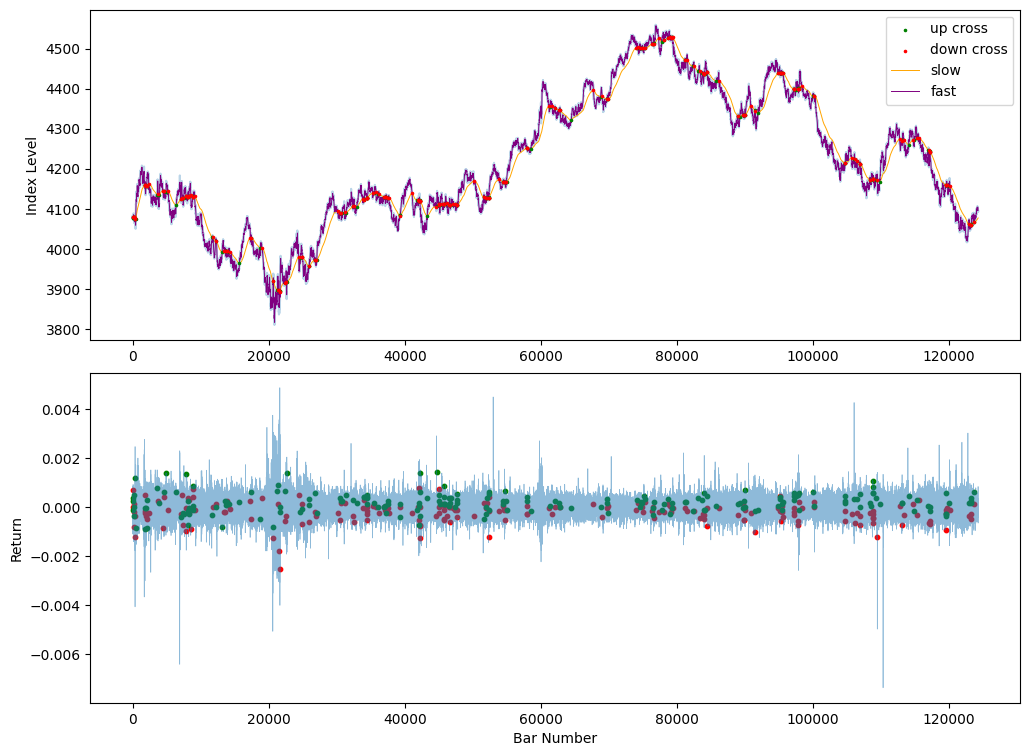

In [9]:
# Plot the events in price space and return space
fig, ax = plt.subplots(2, 1, figsize=(12, 9))

plt.subplots_adjust(hspace=0.1)  # Example: 0.3 times the average axis width

ax[0].scatter(up_crosses, fast[up_crosses], marker=".", color="green", s=10, zorder=10, label="up cross")
ax[0].scatter(down_crosses, fast[down_crosses], marker=".", color="red", s=10, zorder=10, label="down cross")

ax[0].plot(rolled["close"], alpha=0.3)
ax[0].plot(slow, label="slow", color="orange", linewidth=0.7) 
ax[0].plot(fast, label="fast", color="purple", linewidth=0.7)

ax[0].legend()

ax[0].set_ylabel("Index Level")

ax[1].plot(rolled["return"], linewidth=0.5, alpha=0.5)
ax[1].scatter(down_crosses, rolled.loc[down_crosses]["return"], s=10, color="red", label="down cross")
ax[1].scatter(up_crosses, rolled.loc[up_crosses]["return"], s=10, color="green", label="up cross")

ax[1].set_ylabel("Return")
ax[1].set_xlabel("Bar Number")

In [10]:
rolling_vol = get_daily_rolling_volatility(rolled)

events = sorted(list(up_crosses) + list(down_crosses))
vertical_barriers = get_vertical_barriers(rolled, time_thresh="10d")


lower_series = rolling_vol["daily volatility"]
upper_series = rolling_vol["daily volatility"]

# made large to ensure there are lots of overlapping events
upper_factor = 6
lower_factor = 6

labelled_events = detect_crossed_barriers_for_events(rolled, 
                                                     events, 
                                                     lower_series, 
                                                     upper_series, 
                                                     lower_factor, 
                                                     upper_factor,
                                                     vertical_barriers).dropna()

labelled_events = labelled_events[labelled_events["barrier"]!=0]

In [12]:
event_side_frame = pd.DataFrame(index=events)
event_side_frame.loc[up_crosses, "cross direction"] = 1
event_side_frame.loc[down_crosses, "cross direction"] = -1

observation_frame = labelled_events.copy()
observation_frame["event observation time"] = rolled.loc[labelled_events.index, "last transaction"]
observation_frame["label observation time"] = rolled.loc[labelled_events["first touch"], "last transaction"].values
observation_frame = observation_frame.reset_index(names="event start")

observation_frame["rolling std"] = rolled["close"].ewm(span=100).std()[observation_frame["event start"]].reset_index(drop=True)
observation_frame["cross direction"] = event_side_frame["cross direction"].reset_index(drop=True)

observation_frame["barrier"] = observation_frame["barrier"].astype(int)
observation_frame["cross direction"] = observation_frame["cross direction"].astype(int)

dummies = pd.get_dummies(observation_frame["cross direction"], prefix="cross direction", drop_first=True)
observation_frame = observation_frame.drop(columns=["cross direction"]).join(dummies)

In [13]:
observation_frame.head(5)

,event start,barrier,absolute return,first touch,event observation time,label observation time,rolling std,cross direction_1
0,1765,-1,0.011247,2721,2023-02-03 09:10:42.769839635,2023-02-06 10:25:24.436573071,11.316984,True
1,1767,-1,0.010517,2715,2023-02-03 09:23:22.333857616,2023-02-06 09:45:18.467855936,11.216945,False
2,1775,1,0.006136,2102,2023-02-03 10:34:38.381761710,2023-02-03 15:24:07.747795491,10.945765,True
3,1783,-1,0.004808,1818,2023-02-03 11:48:34.374703672,2023-02-03 13:31:40.111127586,10.558833,False
4,1814,-1,0.016577,5664,2023-02-03 13:31:00.482874698,2023-02-10 09:59:33.963535031,9.883545,True


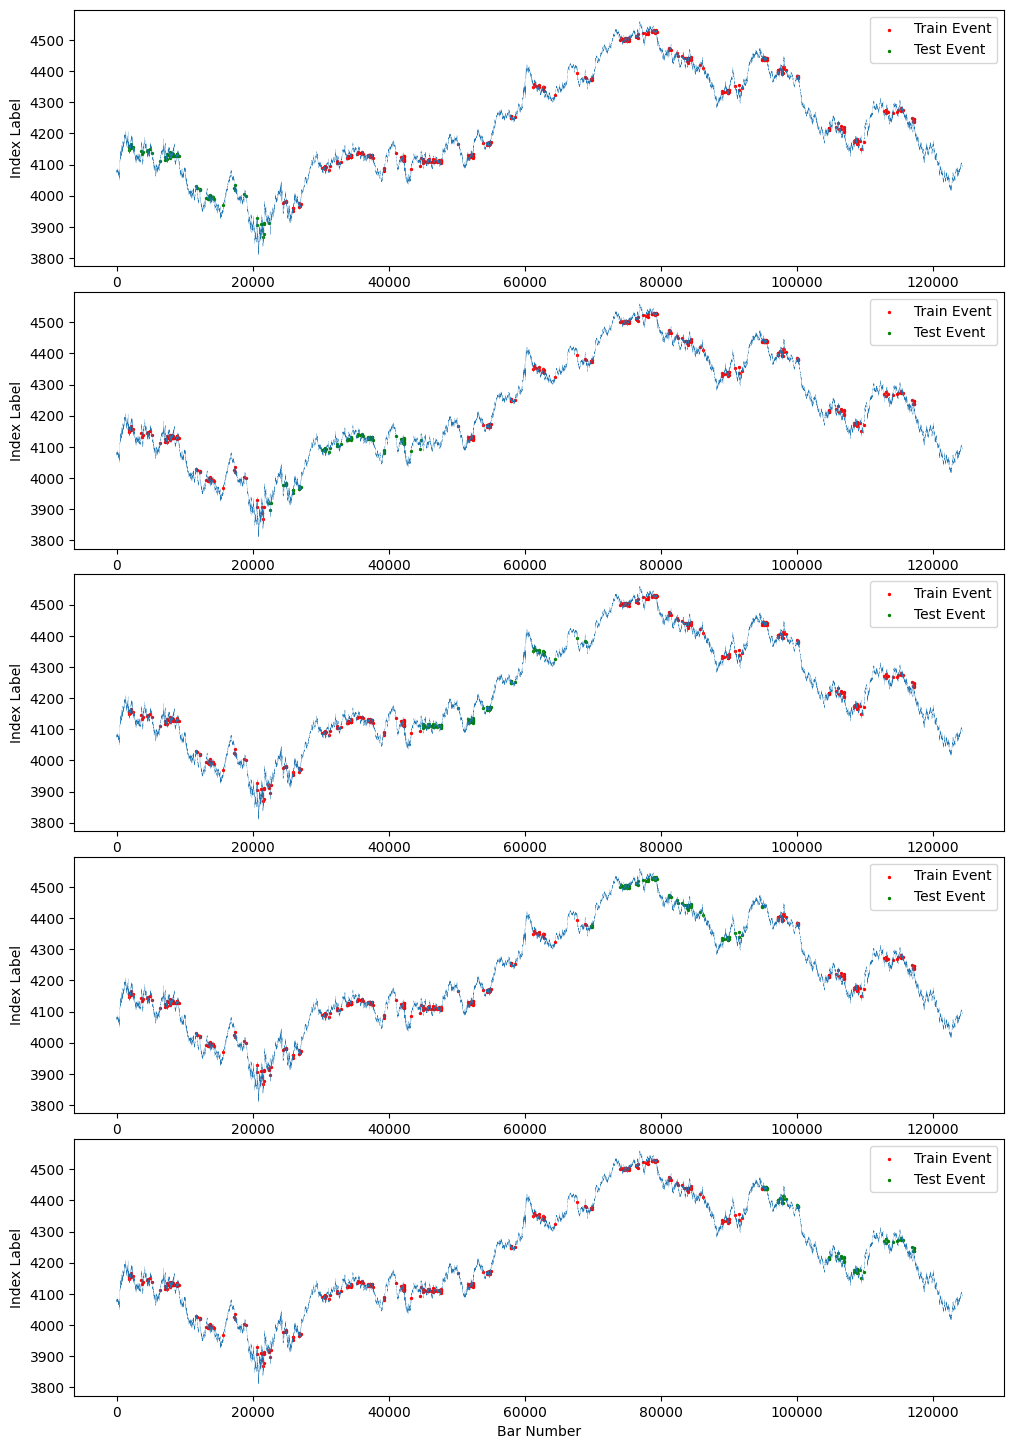

In [36]:
# Visualize the Purged KFold Cross Validation Scheme used below
n_splits = 5
embargo_size = int(0.01*rolled.shape[0])

fig, ax = plt.subplots(n_splits, 1, figsize=(12, 18))

plt.subplots_adjust(hspace=0.1)  

Validator = PurgedKFold(n_splits=n_splits, embargo_size=embargo_size)
for idx, (train_indices, test_indices) in enumerate(Validator.split(observation_frame)):

    training_label = "Train Event"
    ax[idx].scatter(observation_frame.loc[train_indices, "event start"], 
            rolled.loc[observation_frame.loc[train_indices, "event start"], "close"], s=2, color="red", label=training_label)
    
    testing_label = "Test Event"
    ax[idx].scatter(observation_frame.loc[test_indices, "event start"], 
            rolled.loc[observation_frame.loc[test_indices, "event start"], "close"], s=2, color="green", label=testing_label)
    ax[idx].plot(rolled["close"], linewidth=0.1)

    ax[idx].legend()
    ax[idx].set_ylabel("Index Label")
    ax[idx].set_xlabel("Bar Number")


### 7.1

Why is shuffling a dataset before conducting k-fold CV generally a bad idea in
finance? What is the purpose of shuffling? Why does shuffling defeat the purpose
of k-fold CV in financial datasets?

In general, the purpose of shuffling is to ensure that the model is not learning from the ordering of data observations itself, especially if that ordering is not preseved in the test set.  Consider training a model to classify images of cats vs. dogs. If the model trains on all cats and then on all dogs, its weights will tend to bounce between values where everything is classified as a cat, and then everything is classified as a dog.  This slows down the learning process. In addition, if the dataset is not shuffled, the validation set could be completely different than the training set due to the ordering of the data, so the model does not train on diverse enough data to generalize.

One might think that shuffling is a good idea in finance. For example, if our dataset is a bull run followed by a bear run, then during training, a model predicting returns could get stuck in a cycle of always buying followed by always selling, ultimately learning nothing.  Shuffling might prevent this from occuring.

However, shuffling in before conducting k-fold CV is a bad idea in finance because it can lead to data leakage. If our dataset consists of many overalapping event-label pairs, then the data is not IID.  If we shuffle the data, then information from the testing set could end up in the training set.

### 7.2

Take a pair of matrices (X, y), representing observed features and labels. These
could be one of the datasets derived from the exercises in Chapter 3.

(a) Derive the performance from a 10-fold CV of an RF classifier on (X, y), without shuffling.

(b) Derive the performance from a 10-fold CV of an RF on (X, y), with shuffling.

(c) Why are both results so different?

(d) How does shuffling leak information?

In [27]:
def shuffle_experiment(features, train, cross_validator):
    
    experiment_results = []
    for _ in range(20):
        accuracy_scores = []
        for train, test in cross_validator.split(observation_frame):
            
            clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=10)
            clf_bagged = BaggingClassifier(estimator=clf_tree, n_estimators=5) 
        
            X, y = observation_frame.loc[train, features], observation_frame.loc[train, "barrier"]
            fit = clf_bagged.fit(X=X, y=y)
        
            pred=fit.predict(observation_frame.loc[test, features])        
            
            accuracy_scores.append( accuracy_score(observation_frame.loc[test, "barrier"], pred) )
    
            experiment_results.append(np.array(accuracy_scores).mean())
    
    return experiment_results
    
    

In [29]:
# Compare the testing error for shuffle on vs. off
# First for shuffle on

features = ["rolling std", "cross direction_1"]
shuffle = True
cross_validator = KFold(n_splits=5, shuffle=shuffle)

experiment_results = shuffle_experiment(features, train, cross_validator)
print( f"Average test error for 20 trials of 5-fold CV, shuffle {shuffle}:", np.array(experiment_results).mean())

Average test error for 20 trials of 5-fold CV, shuffle True: 0.5294592492492493


In [37]:
# Now for shuffle off
shuffle = False
cross_validator = KFold(n_splits=5, shuffle=shuffle)

experiment_results = shuffle_experiment(features, train, cross_validator)
print( f"Average test error for 20 trials of 5-fold CV, shuffle {shuffle}:", np.array(experiment_results).mean())

Average test error for 20 trials of 5-fold CV, shuffle False: 0.5091148048048048


There is a clear difference in testing accuracy when shufflign is on vs. off. The testing accuracy is inflated when shuffling is turned on, indicating information leakage.

### 7.3

Take the same pair of matrices (X, y) you used in exercise 2.

(a) Derive the performance from a 10-fold purged CV of an RF on (X, y), with
1% embargo.

(b) Why is the performance lower?

(c) Why is this result more realistic?

In [35]:
clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=10)
clf_bagged = BaggingClassifier(estimator=clf_tree, n_estimators=5) 

experiment_results = []
for _ in range(20):
    
    scores = cvScore(clf_bagged, observation_frame, scoring="accuracy", 
                     features=["rolling std", "cross direction_1"], cv=5, embargo_size=(rolled.shape[0]*0.01), report=False)
    experiment_results.append(scores.mean())

print(f"Average test error for 20 trials of 5-fold CV, purged & embargo:", np.array(experiment_results).mean())

Average test error for 20 trials of 5-fold CV, purged & embargo: 0.48891531531531535


Using a purged and embargoed cross validation scheme gives a result which is far more deflated and realistic than the methods above. The performance is lower beacuse we have purged event-label pairs near the border of the training and test set, which reduces data leakage.

### 7.4

In this chapter we have focused on one reason why k-fold CV fails in financial
applications, namely the fact that some information from the testing set leaks into
the training set. Can you think of a second reason for CV’s failure?

Cross validation may also fail because financial time series are not stationary. The goal of CV is to provide an estiamte for the test error when a model is deployed. This fails if the properties of the time series changes from when the model was cross validated to deployment

### 7.5

Suppose you try one thousand configurations of the same investment strategy,
and perform a CV on each of them. Some results are guaranteed to look good,
just by sheer luck. If you only publish those positive results, and hide the rest,
your audience will not be able to deduce that these results are false positives, a
statistical fluke. This phenomenon is called “selection bias.”

(a) Can you imagine one procedure to prevent this?

(b) What if we split the dataset in three sets: training, validation, and testing?
The validation set is used to evaluate the trained parameters, and the testing
is run only on the one configuration chosen in the validation phase. In what
case does this procedure still fail?

(c) What is the key to avoiding selection bias?

One method to mitigate selection bias is to account for the number of hypotheses when reporting results, i.e. to use methods for multiple hypothesis testing. For example, one could use the Bonferroni method or the Benjamini–Hochberg procedure.

As suggested, one could also hold out an additional testing set, where only the best model from cross validation is evaluated. In practice, this will not completely prevent the problem. If a model fails on the testing set, then one must start the development process again, building a new model from scratch. If this is done enough times, information from the test set effectively leaks into the training sets as different models are considered. 